In [34]:
import sys
!conda install --yes --prefix {sys.prefix} numpy tensorflow pandas seaborn matplotlib sklearn quandl


DirectoryNotACondaEnvironmentError: The target directory exists, but it is not a conda environment.
Use 'conda create' to convert the directory to a conda environment.
  target directory: /Library/Frameworks/Python.framework/Versions/3.7




<center> <h1>Predicción del precio del Bitcoin</h1> 
<img src="https://www.unicaribe.mx/static/img/logo.png">
<h1> Rafael Lagunas Guitron</h1>
<h2>150300810</h2>
<h1> Ingeniería en Datos e Inteligencia Organizacional</h1>
<h1> </h1>
</center>

### Introducción:

En esta era moderna, es importante tener conocimiento de las criptomonedas, en  especial la $BITCOIN$, al ser la principal del mercado, hay que tomarse el tiempo de investigar e informarse sobre el tema, ya qué, es el mercado del futuro que ya nos está alcanzando, es por eso que, es importante contar con un estudio del mercado para poder predecir el precio, alcista o bajista, lo cual nos llevara a la realizacionn un modelo básico de red neuronal profunda para predecir el precio de Bitcoin en función de los datos históricos.


# Predicción de precio del bitcoin utilizando Keras de Tensorflow

# Parte 1, Recoleccion de datos

Nuestro conjunto de datos proviene de Yahoo! Finance y cubre todos los datos disponibles el cual cargaremos como un dataframe de pandas.

In [35]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import quandl
import datetime

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [36]:
csv_path = "BTC-USD.csv"

In [37]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [38]:
df = df.sort_values('Date')

Ordenamos los datos por fecha por si se encuentra un dato erroneo, a continuacion una muestra de como se observan los datos

In [39]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-10-01,387.427002,391.378998,380.779999,383.614990,383.614990,26229400
1,2014-10-02,383.988007,385.497009,372.946014,375.071991,375.071991,21777700
2,2014-10-03,375.181000,377.695007,357.859009,359.511993,359.511993,30901200
3,2014-10-04,359.891998,364.487000,325.885986,328.865997,328.865997,47236500
4,2014-10-05,328.915985,341.800995,289.295990,320.510010,320.510010,83308096


Tenemos un total de 3201 puntos de datos que representan el precio de Bitcoin-USD durante 3201 días

In [40]:
df.shape

(2775, 7)

Text(0, 0.5, 'Close Price (USD)')

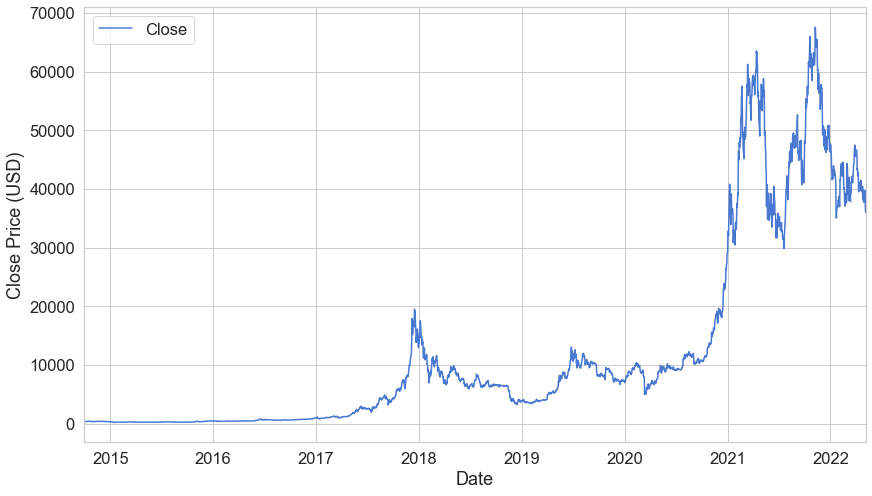

In [41]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Parte 2, Normalizacion de datos

A continuacion, vamos a escalar los datos dentro del rango [0,1], utilizaremos la funcion MinMaxScaler, la cual transforma las características escalando cada una de ellas a un rango determinado. Este estimador escala y traduce cada característica individualmente de manera que se encuentre en el rango dado en el conjunto de entrenamiento,por ejemplo,entre cero y uno. donde min,max=rango_de_características,  



El escalador espera que los datos tengan la forma de (x, y), por lo que agregamos una dimensión ficticia usando reshape antes de aplicarla.

In [42]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [43]:
scaled_close.shape

(2775, 1)

In [44]:
np.isnan(scaled_close).any()

False

Usamos isnan como máscara para filtrar los valores de NaN. Nuevamente remodelamos los datos después de eliminar los NaN.

In [45]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [46]:
scaled_close = scaled_close.reshape(-1, 1)

In [47]:
np.isnan(scaled_close).any()

False

# Part 3, Preprocesamiento

Para la realizacion del modelo de red neuronal, se necesita que los datos estén en 3 dimensiones. Necesitamos dividir los datos en secuencias de una longitud preestablecida. La forma que queremos obtener es:
[batch_size, sequence_length, n_features]

También queremos guardar algunos datos para realizar pruebas.

In [48]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [49]:
X_train.shape

(2541, 99, 1)

In [50]:
X_test.shape

(134, 99, 1)

El proceso de construcción de secuencias funciona creando una secuencia de una longitud específica en la posición 0. Luego cambiamos una posición a la derecha (por ejemplo, 1) y creamos otra secuencia. El proceso se repite hasta que se utilizan todas las posiciones posibles.

Guardamos el 5% de los datos para las pruebas. Los conjuntos de datos se ven así:

(2945, 99, 1)


(156, 99, 1)


Nuestro modelo utilizará 2945 secuencias que representan 99 días de cambios en el precio de Bitcoin cada una para el entrenamiento. Vamos a predecir el precio para 156 días en el futuro.

# Parte 4, Modelado
Para el Modelado de datos utilizaremos la libreria LSTM de keras.

Según Palash Sharma(Febrero 1, 2021)
Long Short-Term Memory Network o LSTM, es una variación de una red neuronal recurrente (RNN) que es bastante efectiva para predecir secuencias largas de datos como oraciones y precios de acciones durante un período de tiempo.

Se diferencia de una red feedforward normal porque hay un circuito de retroalimentación en su arquitectura. También incluye una unidad especial conocida como celda de memoria para retener la información pasada durante más tiempo para hacer una predicción efectiva.

De hecho, LSTM con sus celdas de memoria es una versión mejorada de los RNN tradicionales que no pueden predecir utilizando una secuencia de datos tan larga y se encuentran con el problema del gradiente de fuga.


![LST](https://machinelearningknowledge.ai/ezoimgfmt/953894.smushcdn.com/2611031/wp-content/uploads/2021/01/LSTM-282x300.png?lossy=0&strip=1&webp=1&ezimgfmt=ng:webp/ngcb1)


Sharma, P. (2021, February). Machinelearningknowledge.ai. https://machinelearningknowledge.ai/keras-lstm-layer-explained-for-beginners-with-example/#:~:text=Long%20Short%2DTerm%20Memory%20Network,feedback%20loop%20in%20its%20architecture.


##Construcción del modelo LSTM
Estamos creando una red neuronal recurrente LSTM de 3 capas. Usamos Dropout con una tasa del 20% para combatir el sobreajuste durante el entrenamiento:
‌

In [51]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

2022-05-06 16:06:17.941657: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Parte 5, entrenamiento
Usaremos el Mean Squared Error como función de pérdida y el optimizador de Adam.

El error cuadrático medio (MSE) te dice qué tan cerca está una línea de regresión de un conjunto de puntos. Lo hace tomando las distancias desde los puntos hasta la línea de regresión (estas distancias son los "errores") y elevándolas al cuadrado. La cuadratura es necesaria para eliminar cualquier signo negativo. También da más peso a las diferencias más grandes. Se llama el error cuadrático medio ya que estás encontrando el promedio de un conjunto de errores. Cuanto menor sea el MSE, mejor será el pronóstico.
![MSE](https://cdn-media-1.freecodecamp.org/images/hmZydSW9YegiMVPWq2JBpOpai3CejzQpGkNG)

In [52]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [53]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
36/36 [==============================] - 47s 966ms/step - loss: 0.0042 - val_loss: 0.2613
Epoch 2/50
36/36 [==============================] - 28s 776ms/step - loss: 0.0117 - val_loss: 0.2206
Epoch 3/50
36/36 [==============================] - 27s 741ms/step - loss: 0.0189 - val_loss: 0.0280
Epoch 4/50
36/36 [==============================] - 30s 838ms/step - loss: 0.0118 - val_loss: 0.3539
Epoch 5/50
36/36 [==============================] - 26s 715ms/step - loss: 0.0182 - val_loss: 0.0738
Epoch 6/50
36/36 [==============================] - 25s 707ms/step - loss: 0.0216 - val_loss: 0.1615
Epoch 7/50
36/36 [==============================] - 28s 780ms/step - loss: 0.0626 - val_loss: 0.2588
Epoch 8/50
36/36 [==============================] - 32s 908ms/step - loss: 0.0122 - val_loss: 0.0491
Epoch 9/50
36/36 [==============================] - 30s 834ms/step - loss: 0.0378 - val_loss: 0.1999
Epoch 10/50
36/36 [==============================] - 27s 762ms/step - loss: 0.0111 - val_lo

In [54]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 122ms/step - loss: 0.0029


0.0029111874755471945

Después de un entrenamiento, tenemos la siguiente pérdida de entrenamiento:

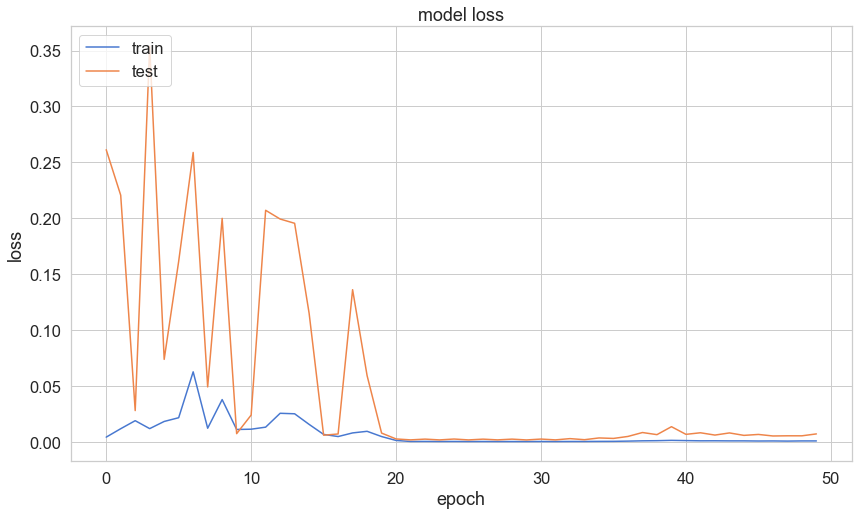

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Parte 6, Prediccion
Realizaremos la predicción del precio de Bitcoin, Putilizaremos escalador para invertir la transformación que hicimos para que los precios ya no estén escalados en el rango [0, 1].

In [56]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

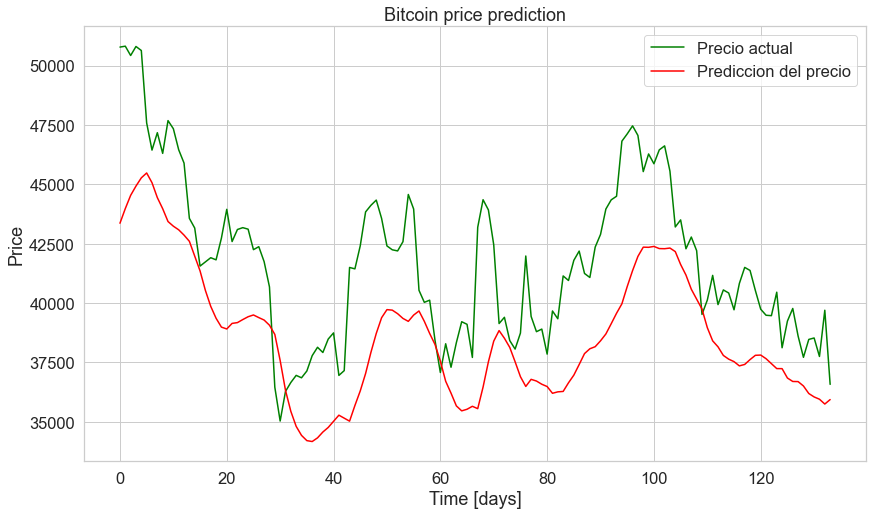

In [57]:
plt.plot(y_test_inverse, label="Precio actual", color='green')
plt.plot(y_hat_inverse, label="Prediccion del precio", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

# Conclusion
Con la red neuronal recurrente LSTM bidireccional en TensorFlow 2, se puede observar una correcta prediccion al precio de bitcoin con respecto al precio actual del bitcoin, el modelo es bastante general y se puede usar para otros conjuntos de datos o moneda.

# Prediccion de precio del bitcoin utilizando Regresion lineal
La regresión lineal permite predecir el comportamiento de una variable (dependiente o predicha) a partir de otra (independiente o predictora). Tiene presunciones como la linearidad de la relación, la normalidad, la aleatoridad de la muestra y homogeneidad de las varianzas.

# Parte 1, recoleccion de datos
Extraeremos las fechas y los precios del bitcoin, para ello, existe otro metodo el cual realizaremos, utilizando las libreria quandi, Quandl es una plataforma que proporciona a sus usuarios conjuntos de datos económicos, financieros y alternativos.

In [58]:
#Definir fechas
start_date = datetime.date(2019, 3, 1)
end_date = datetime.date.today()

#Input API KEY
quandl.ApiConfig.api_key = 'XE6RV-AUY5Z8ncD6xFUg'

#Extraer Datos de Quandl
data = quandl.get('BITSTAMP/USD', start_date=start_date, end_date=end_date)
data = data.reset_index()
prices = data['Last'].tolist()
dates = data.index.tolist()
data

,Date,High,Low,Last,Bid,Ask,Volume,VWAP
0,2019-03-01,3897.62,3755.00,3791.36,3790.27,3792.24,6747.880272,3815.53
1,2019-03-02,3845.30,3789.50,3807.05,3805.00,3807.05,4761.410159,3816.28
2,2019-03-03,3818.75,3760.00,3810.46,3809.73,3810.46,3259.743125,3802.06
3,2019-03-04,3822.39,3756.00,3789.52,3786.85,3789.70,2508.086491,3797.08
4,2019-03-05,3806.90,3670.00,3698.65,3698.01,3698.65,7294.069980,3716.23
...,...,...,...,...,...,...,...,...
835,2021-06-16,40506.59,38333.00,38575.47,38520.62,38548.95,3845.249032,39335.90
836,2021-06-17,39553.05,37350.00,37963.82,37913.00,37954.07,3637.470886,38451.77
837,2021-06-18,38208.68,35143.68,35596.79,35590.45,35614.99,4265.269101,36876.99
838,2021-06-19,36440.00,34718.21,35550.59,35550.95,35572.76,3133.523340,35745.45


# Parte 2, Preprocesamiento
Convertiremos los ID en un vector utilizando reshape para poder inicializar el modelo con estos valores

In [59]:
dates = np.reshape(dates, (len(dates),1))
prices = np.reshape(prices, (len(prices),1))


In [60]:
regressor = LinearRegression()
regressor.fit(dates, prices)
predicted = regressor.predict(dates)
score = regressor.score(dates, prices)


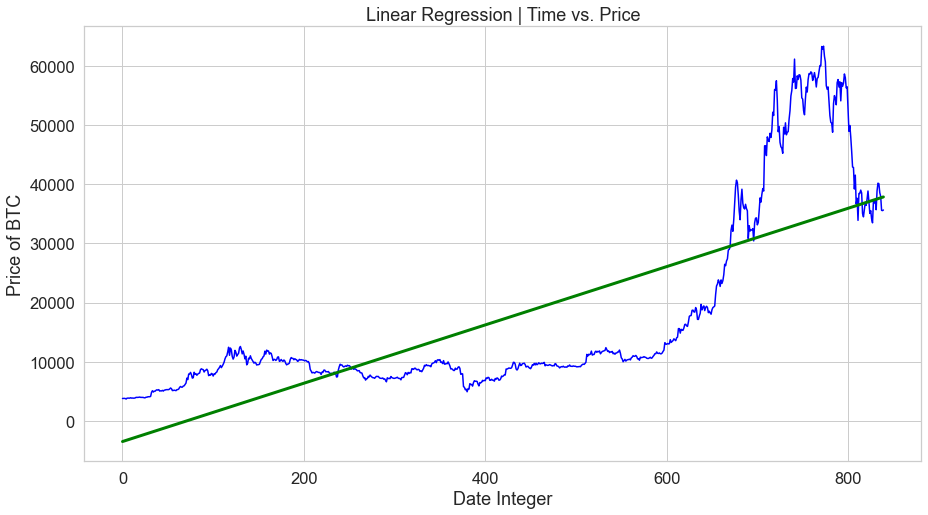

Puntuación de precisión para la regresión lineal estándar 0.5724899039016562


In [61]:
plt.figure(figsize=(15,8)) 
plt.plot(dates, prices, color='blue', label='Acutal Price')
plt.plot(dates, predicted, color='green', linewidth=3, label='Predicted Price')
plt.title('Linear Regression | Time vs. Price')

plt.xlabel('Date Integer')
plt.ylabel('Price of BTC')
plt.show()

print('Puntuación de precisión para la regresión lineal estándar', score)

#Parte 3, entrenamiento
Dividiremos el conjunto de datos de entrenamiento y el conjuunto de prueba

scikit-learn hace que sea muy fácil dividir nuestro conjunto de datos en datos de entrenamiento y datos de prueba. Para hacer esto, necesitaremos importar la función train_test_split desde el módulo model_selection de scikit-learn.

Los datos de train_test_split aceptan tres argumentos:

Nuestra matriz x


nuestra matriz y


El tamaño deseado de nuestros datos de prueba


Con estos parámetros, la función train_test_split dividirá nuestros datos por nosotro, se dea que nuestros datos de prueba sean el 33% del conjunto de datos completo.

In [62]:
xtrain, xtest, ytrain, ytest = train_test_split(dates, prices, test_size=0.33, random_state=42)

La función train_test_split devuelve una lista de Python de longitud 4, donde cada elemento de la lista es x_train, x_test, y_train e y_test, respectivamente. Luego usamos el desempaquetado de listas para asignar los valores adecuados a los nombres correctos de las variables.

Ahora que hemos dividido correctamente nuestro conjunto de datos, es hora de construir y entrenar nuestro modelo de aprendizaje automático de regresión lineal.

Lo primero que debemos hacer es importar el estimador LinearRegression de scikit-learn.


```ruby
from sklearn.linear_model import LinearRegression
```

A continuación, Podemos usar el método de ajuste de scikit-learn para entrenar nuestro modelo en nuestros datos de entrenamiento.

In [63]:
regressor.fit(xtrain, ytrain)

LinearRegression()

Nuestro modelo ya ha sido entrenado.

# Parte 4, Grafico de entrenamiento y prueba

Gráfico de conjuntos de entrenamiento


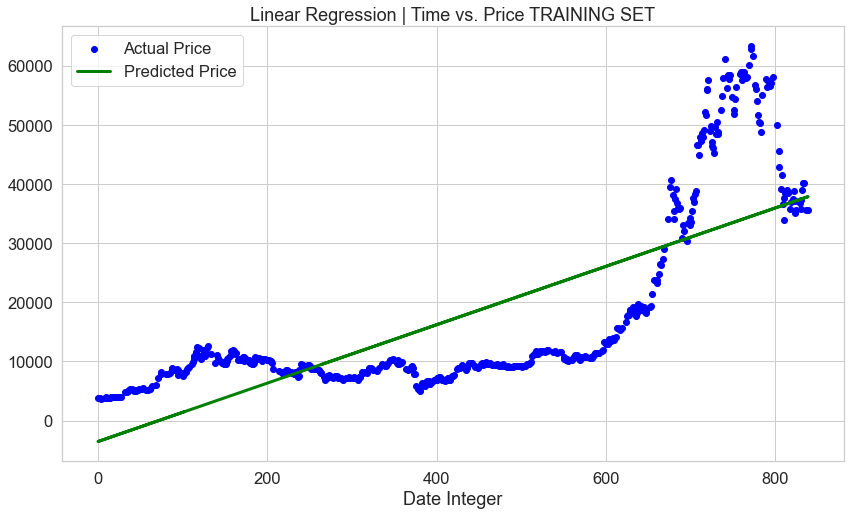

Puntuación de precisión para el conjunto de prueba 0.5722050905022544


In [64]:
plt.scatter(xtrain, ytrain, color='blue', label= 'Actual Price') #trazado de los puntos de datos iniciales
plt.plot(xtrain, regressor.predict(xtrain), color='green', linewidth=3, label = 'Predicted Price') #trazado de línea hecha por regresión lineal
plt.title('Linear Regression | Time vs. Price TRAINING SET')
plt.legend()
plt.xlabel('Date Integer')
plt.show()
print('Puntuación de precisión para el conjunto de prueba',regressor.score(xtrain, ytrain))

Gráfico de conjunto de prueba

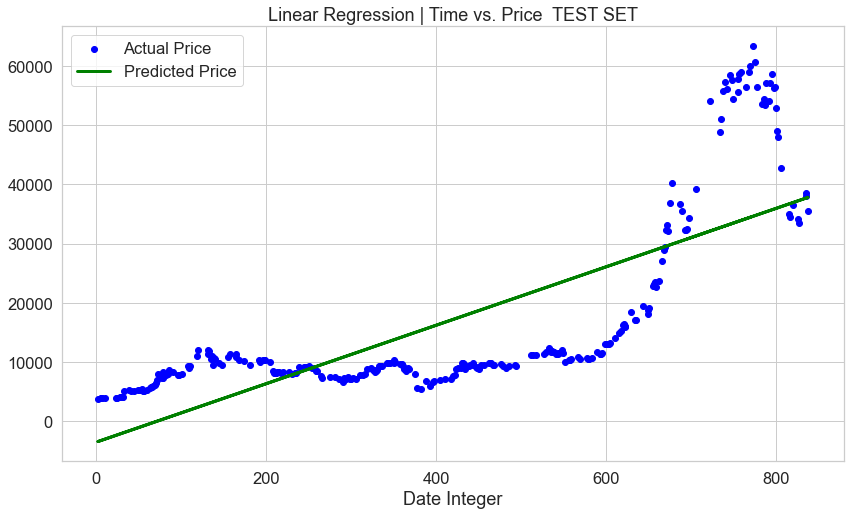

Puntuación de precisión para el conjunto de prueba 0.5728543630829626


In [65]:
plt.scatter(xtest, ytest, color='blue', label= 'Actual Price') #trazado de los puntos de datos iniciales
plt.plot(xtest, regressor.predict(xtest), color='green', linewidth=3, label = 'Predicted Price') #trazar de línea hecha por regresión lineal
plt.title('Linear Regression | Time vs. Price  TEST SET')
plt.legend()
plt.xlabel('Date Integer')
plt.show()
print('Puntuación de precisión para el conjunto de prueba', regressor.score(xtest, ytest))

# Parte 5, predicción para un año a partir de ahora
Crearemos una variable llamada prediccion, utilizaremos la funcion predict para añadirle un año a la prediccion y veremos cuano será el precio del bitcoin.

In [66]:
prediccion = regressor.predict([[1863+365]])
print('Según el modelo de regresión lineal, el precio de BTC será', int(prediccion[0][0]), "en un año.")

Según el modelo de regresión lineal, el precio de BTC será 106395 en un año.


# Conclusiones
Tuvimos éxito en gran medida en la predicción de los precios de Bitcoin. Pero, en general, esto no funcionará bien en el mundo real, el modelo de regresion linea obtuvo una buena Puntuación de precisión para el conjunto de prueba lo cual nos permitio desarrollar una prediccion del precio dentro de un año

# Regresion de vector
Support Vector Regression es un algoritmo de aprendizaje supervisado que se utiliza para predecir valores discretos. Support Vector Regression utiliza el mismo principio que las SVM. La idea básica detrás de SVR es encontrar la mejor línea de ajuste.

SVR requiere los datos de entrenamiento: {X, Y} que cubre el dominio de interés y está acompañado por soluciones en ese dominio

In [67]:
from sklearn.svm import SVR
svr_lin = SVR(kernel = 'linear', C=1e3)

Utilizamos el método de ajuste de scikit-learn para entrenar nuestro modelo en nuestros datos de entrenamiento.

In [68]:
svr_lin.fit(dates,prices)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1000.0, kernel='linear')

## Graficamos los resultados


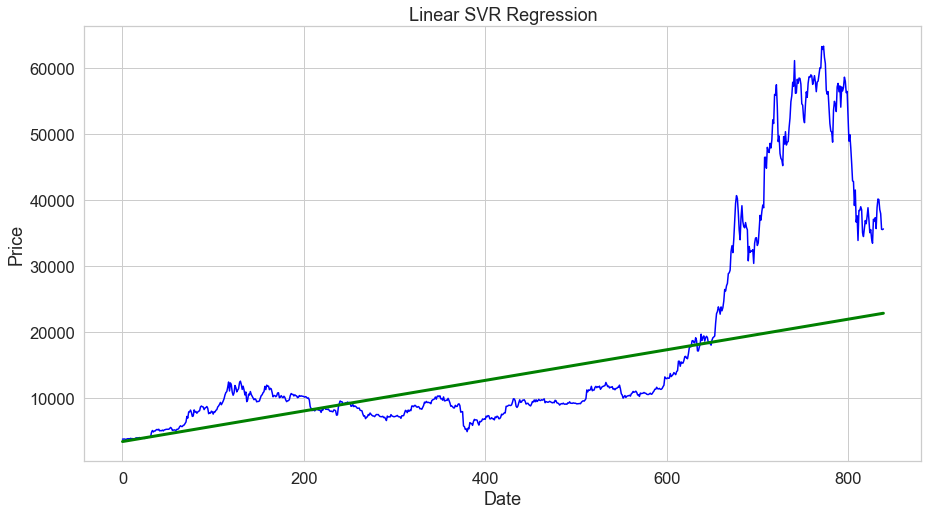

In [69]:
plt.figure(figsize=(15,8))
plt.plot(dates, prices, color='blue', label='Acutal Price')
plt.plot(dates, svr_lin.predict(dates), color='green', linewidth=3, label='Linear SVR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Linear SVR Regression')
plt.show()

Realizaremos la prediccion de un año a partir de ahora para comparar con la regresion lineal

In [70]:
predicted = svr_lin.predict(dates)
score = svr_lin.score(dates, prices)

#make a prediction for a year from now
year_from_now = svr_lin.predict([[1863+365]])
print("Puntuación de precisión para el modelo SVR lineal", score)
print('De acuerdo con el modelo de regresión de vector de soporte lineal, el precio de BTC será', int(year_from_now), "en un año")

Puntuación de precisión para el modelo SVR lineal 0.346484273159001
De acuerdo con el modelo de regresión de vector de soporte lineal, el precio de BTC será 55060 en un año


# Conclusion
El modelo de regresion de vector muestra una diferencia respecto al modelo de regresion lineal, siendo el lineal alcista y el vectorial bajista, de igual forma, el modelo vectorial tiene una puntuación de precisión baja.

Para el mundo real, utilizariamos el modelo de red neuronal LSTM de Keras de Tensorflow, ya que, tiene más similitud con la predicción y los datos actuales, para observar al futuro los precios.